Downloading: "https://github.com/ultralytics/yolov5/zipball/master" to C:\Users\dikae/.cache\torch\hub\master.zip
YOLOv5  2023-12-16 Python-3.10.11 torch-2.1.1+cpu CPU

Fusing layers... 
Model summary: 322 layers, 86180143 parameters, 0 gradients, 203.8 GFLOPs
Adding AutoShape... 


Using Device: cpu
Detected image saved at image_croping_0.jpg with confidence 0.91%


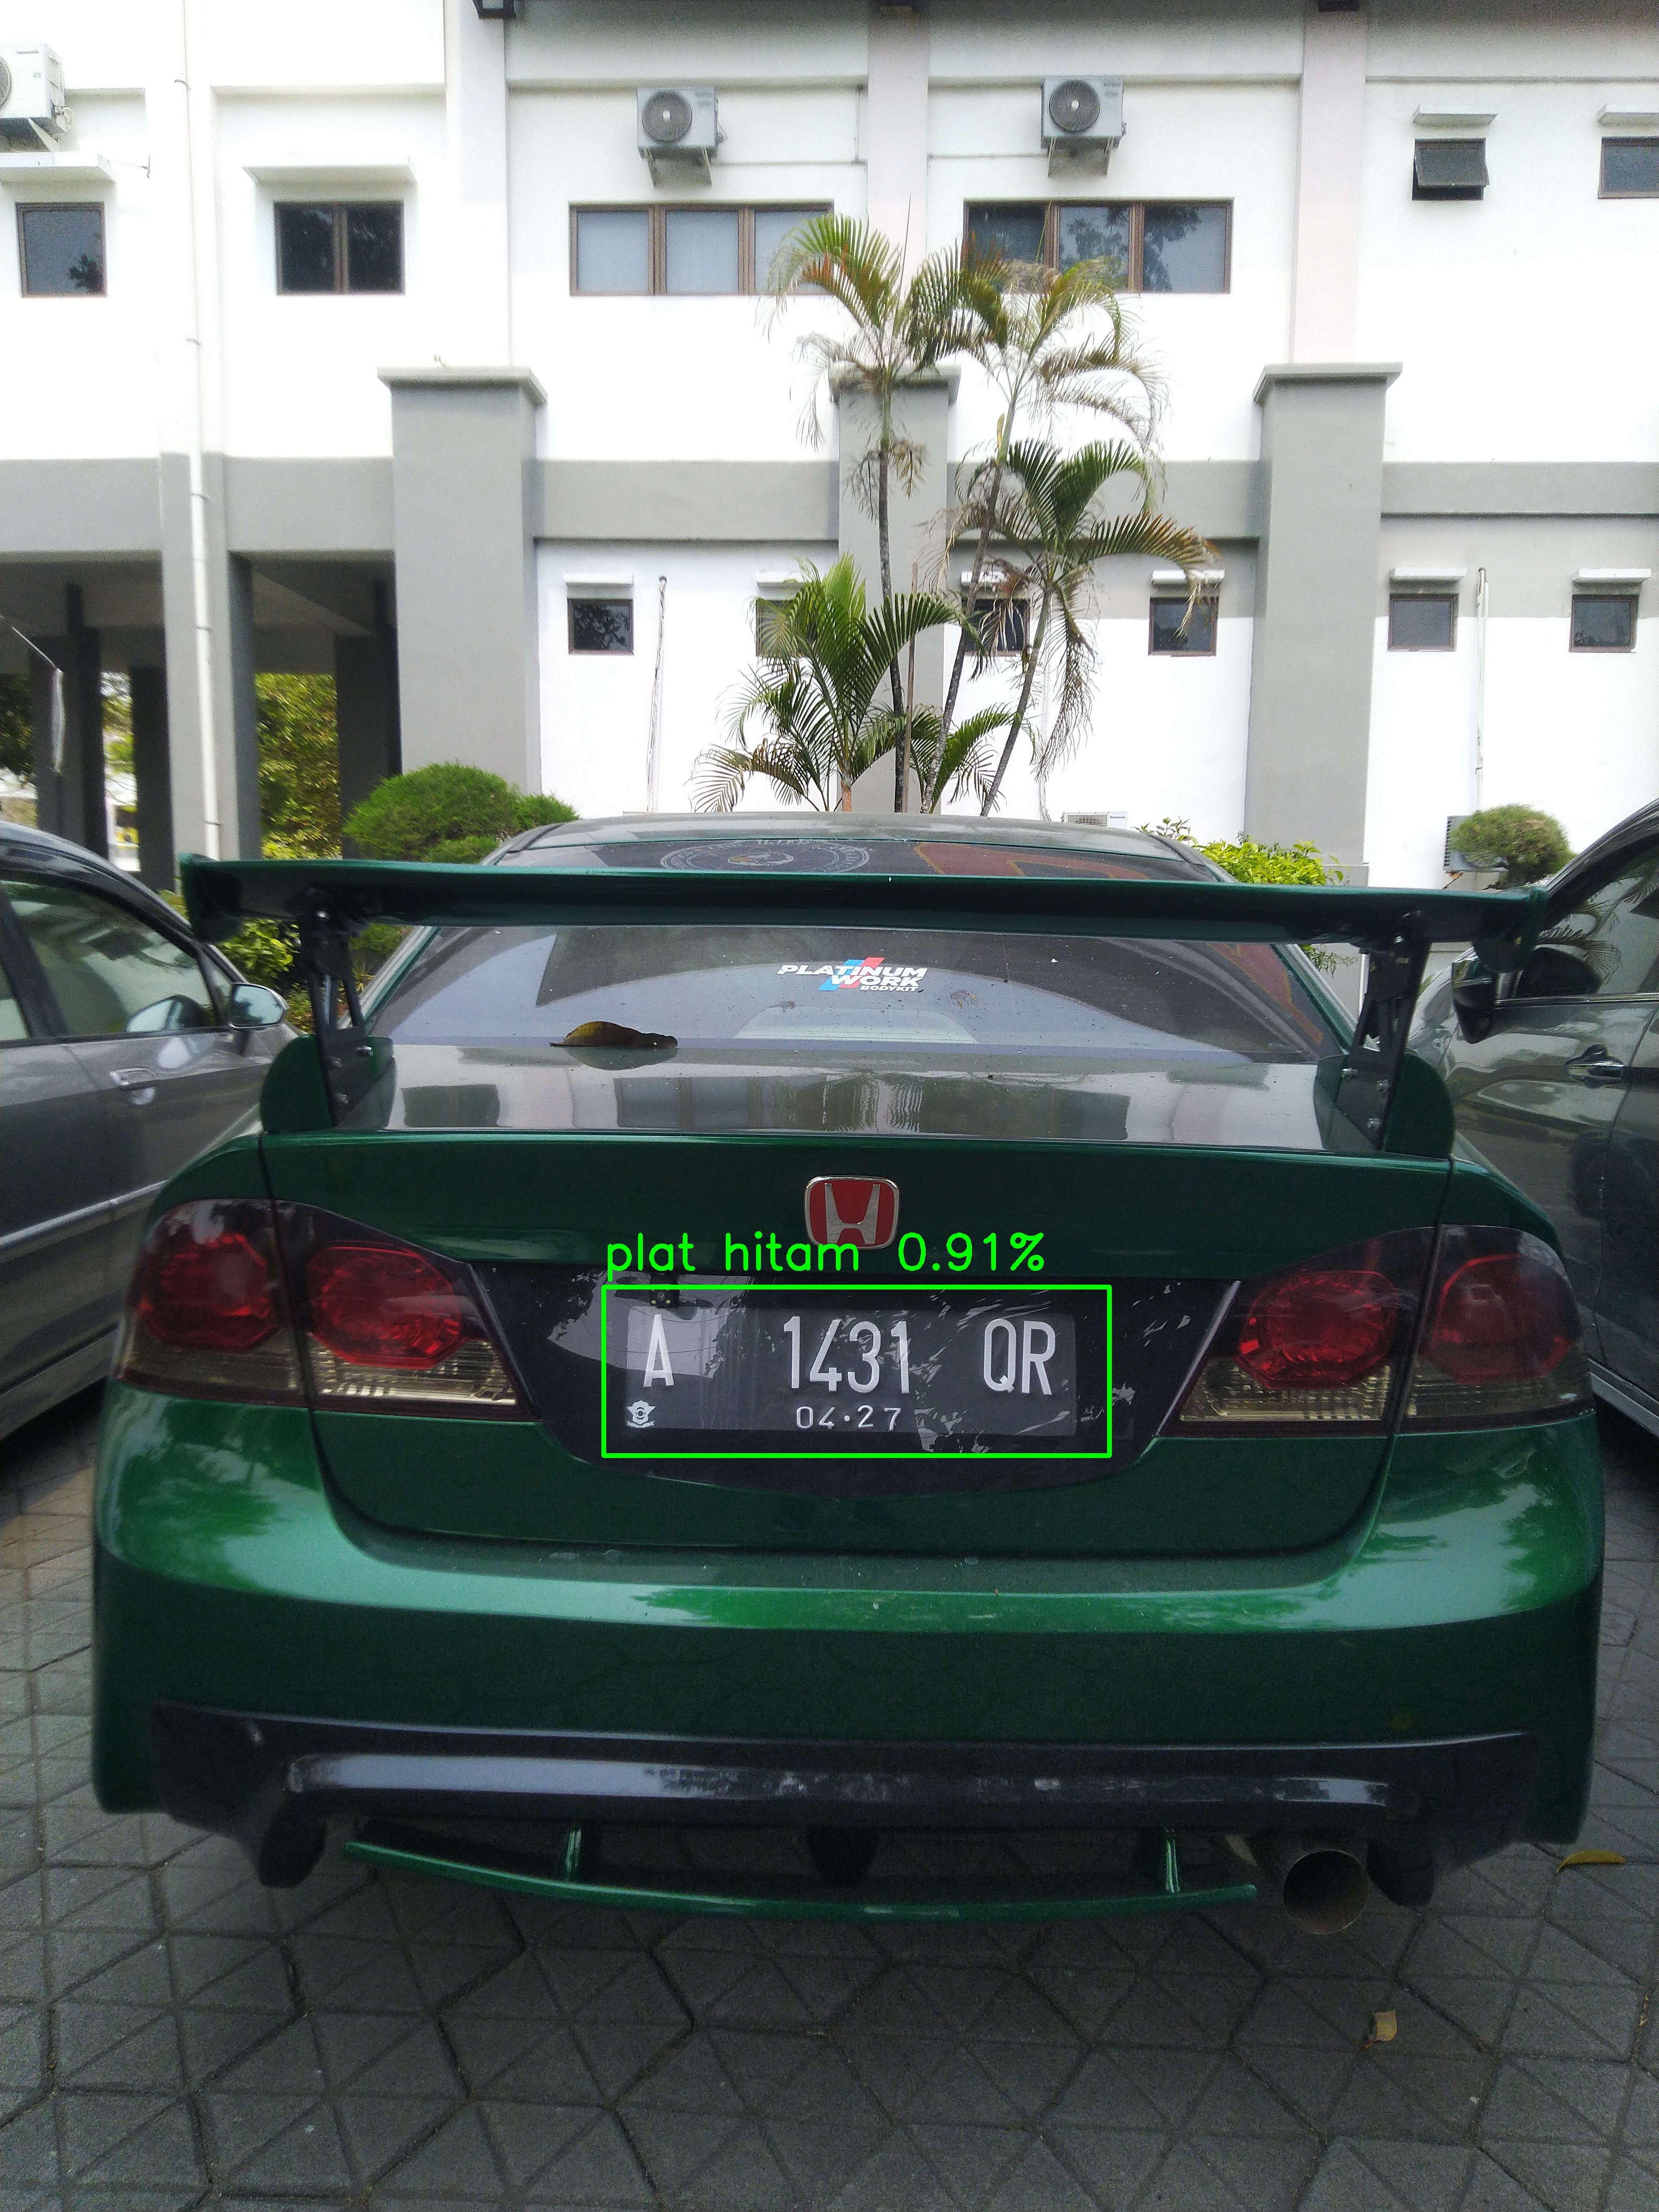

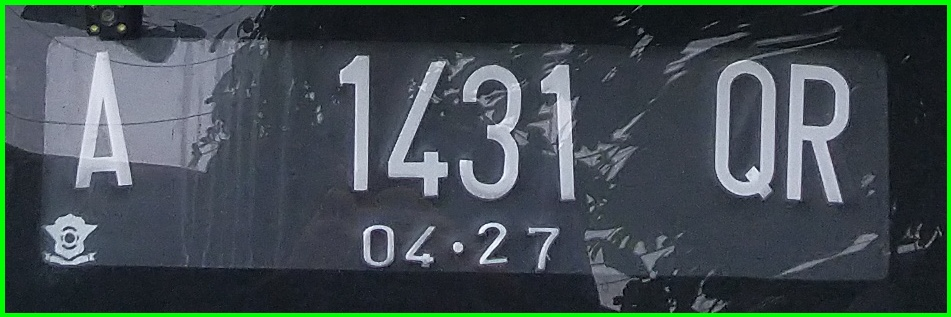

In [1]:
import torch
import cv2
import numpy as np
from IPython.display import Image, display

class LicensePlateDetection:

    def __init__(self, image_path, model_path):
        self.image_path = image_path
        self.model_path = model_path
        self.model = self.load_model()
        self.classes = self.model.names
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        print("Using Device:", self.device)

    def load_model(self):
        """
        Load YOLOv5 model
        """
        if self.model_path:
            model = torch.hub.load(
                'ultralytics/yolov5', 'custom', path=self.model_path, force_reload=True)
        # else:
        #     model = torch.hub.load('ultralytics/yolov5',
        #                            'yolov5s', pretrained=True)
        return model

    def score_image(self, image):
        """
        Calculate scores for a single frame using YOLOv5 model
        """
        self.model.to(self.device)
        image = [image]
        result = self.model(image)
        labels, coordinates = result.xyxyn[0][:, -1], result.xyxyn[0][:, :-1]
        return labels, coordinates

    def detect_license_plate(self):
        """
        Detect license plate in the image using YOLOv5 model
        """
        image = cv2.imread(self.image_path)
        # image = cv2.resize(image, (640, 640))
        return self.score_image(image)

    def class_to_label(self, x):
        return self.classes[int(x)]

    def draw_boxes(self, result, image):
        """
        Draw bounding boxes on the image and save the detected image
        """
        labels, coordinates = result
        n = len(labels)
        x_shape, y_shape = image.shape[1], image.shape[0]

        for i in range(n):
            row = coordinates[i]
            if row[4] >= 0.3:
                x1, y1, x2, y2 = int(
                    row[0]*x_shape), int(row[1]*y_shape), int(row[2]*x_shape), int(row[3]*y_shape)
                bgr = (0, 255, 0)

                confidence_score = row[4]
                text_score = f"{confidence_score:.2f}%"

                # Determine the position of the confidence score text
                x_text_score = x1 + 550
                y_text_score = y1 - 35

                cv2.rectangle(image, (x1, y1), (x2, y2), bgr, 8)
                cv2.putText(image, self.class_to_label(labels[i]), (x1, y1 - 35), cv2.FONT_HERSHEY_SIMPLEX, 3, bgr, 7)
                cv2.putText(image, text_score, (x_text_score, y_text_score), cv2.FONT_HERSHEY_SIMPLEX, 3, bgr, 7)

                # Crop and save the detected region without bounding box
                cropped_region = image[y1:y2, x1:x2]
                saved_image_path = f"image_croping_{i}.jpg"
                cv2.imwrite(saved_image_path, cropped_region)
                print(f"Detected image saved at {saved_image_path} with confidence {confidence_score:.2f}%")

        return image

    def process_image(self):
        """
        Process a single image
        """
        image = cv2.imread(self.image_path)

        result = self.score_image(image)
        image = self.draw_boxes(result, image)

        # Save the detected image
        result_image_path = "image_detected.jpg"
        cv2.imwrite(result_image_path, image)

        # Display the detected image below the code
        display(Image(filename=result_image_path))

        # Display cropped images
        for i in range(len(result[0])):
            cropped_image_path = f"image_croping_{i}.jpg"
            display(Image(filename=cropped_image_path))

if __name__ == "__main__":
    license_plate_detector = LicensePlateDetection("Dataset Plat Nomor/K3 - Plat Hitam Mobil/K3_A1431QR.jpg", "models/best.pt")
    license_plate_detector.process_image()
